Jupyter notebook één team.
In the code below, all needed imports for the following code are made up here.

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

#Imports used for python tf-idf
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report
import sqlalchemy


In [87]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SKIKK\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In the code below, the option to display graphs inline will be set to true.

In [2]:
%config IPCompleter.greedy = True
%matplotlib inline

Reading the data and assign it to the correct variable.

In [54]:
parse_dates = ['Product','Date received', 'Date sent to company']
dtypes = {'Date received': str,
          'Product': "category",
          'Sub-product': "category",
          'Issue': "category",
          'Sub-issue':"category",
          'Consumer complaint narrative':str,
          'Company public response':str,
          'Company':"category",
          'State':"category",
          'ZIP code':str,
          'Tags':"category",
          'Consumer consent provided?':str,
          'Submitted via':"category",
          'Date sent to company':str,
          'Company response to consumer':str,
          'Timely response?':str,
          'Consumer disputed?':str,
          'Complaint ID':int}

# Read the csv file
DS1_data = pd.read_csv("../Data/complaints-2023-04-25_05_07.csv", low_memory = False, dtype = dtypes, parse_dates = parse_dates,nrows=1000)

# Parse yes and no to an boolean
DS1_data[['Timely response?','Consumer disputed?']] = DS1_data[['Consumer disputed?','Timely response?']].replace({'Yes': True, 'No':False}).astype(bool)

# Parse Consent provided an no to an boolean
DS1_data['Consumer consent provided?'] = DS1_data['Consumer consent provided?'].replace({'Consent provided': True, '':False}).astype(bool)

# Drops the missing rows with no  complaint.
DS1_data = DS1_data[pd.notnull(DS1_data['Consumer complaint narrative'])]

# Drops not needed columns
DS1_data.drop(columns=['Sub-issue'])

# Count the amount of issue category's
DS1_data["Issue"].value_counts()

C:\Users\SKIKK\AppData\Local\Temp\ipykernel_24700\2234006997.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DS1_data = pd.read_csv("../Data/complaints-2023-04-25_05_07.csv", low_memory = False, dtype = dtypes, parse_dates = parse_dates,nrows=1000)
C:\Users\SKIKK\AppData\Local\Temp\ipykernel_24700\2234006997.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DS1_data = pd.read_csv("../Data/complaints-2023-04-25_05_07.csv", low_memory = False, dtype = dtypes, parse_dates = parse_dates,nrows=1000)


Issue
Trouble during payment process                                                      221
Struggling to pay mortgage                                                          124
Applying for a mortgage or refinancing an existing mortgage                          72
Loan servicing, payments, escrow account                                             61
Closing on a mortgage                                                                42
Loan modification,collection,foreclosure                                             41
Application, originator, mortgage broker                                             16
Settlement process and costs                                                         15
Credit decision / Underwriting                                                        4
Problem with a credit reporting company's investigation into an existing problem      3
Incorrect information on your report                                                  2
Improper use of your repor

In [57]:
#If db file doesn't exist, create it.
#db = sqlalchemy.create_engine('sqlite:///StaterData.db')
#DS1_data.to_sql("mortgage complaints",db,if_exists="replace")

602

In the next cells we're going to add tf-idf conversion to the string data. The recommended way to run TfidfVectorizer is with smoothing (smooth_idf = True) and normalization (norm='l2') turned on. These parameters will better account for differences in text length, and overall produce more meaningful tf–idf scores. Because this is recommended by python, we turn these settings on.

In [80]:
def tfidf_custom_scoring(input_text):
    # create tf-idf vectorizer and fit to input text
    vectorizer = TfidfVectorizer(stop_words='english',
                             token_pattern=r'\b[a-zA-Z]+\b',
                             analyzer='word',
                             use_idf=True,
                             smooth_idf=True,
                             norm=None, tokenizer=None,
                             preprocessor=None)

    # Fit the data to the vectorizer
    vectorizer.fit(DS1_data['Consumer complaint narrative'])

    # Adds the input from the user to the fit using an transform
    transformed_data = vectorizer.transform([input_text])

    # Get all the feature name(words instead of numbers) corresponding to the array
    feature_names = vectorizer.get_feature_names_out()

    # calculate initial scores and store them in a dictionary
    scores_dict = {name: score for name, score in zip(feature_names, transformed_data.toarray()[0])}

    # adjust scores based on term length and update the dictionary
    for name in feature_names:
        scores_dict[name] *= (1 + 0.01*len(name))

    # create a new array of adjusted scores in the same order as the feature names
    adjusted_scores = np.zeros(len(feature_names))
    for i, term in enumerate(feature_names):
        adjusted_scores[i] = scores_dict[term]

    # return a tuple of the feature names and adjusted scores
    return feature_names, adjusted_scores

In [58]:
# Replace alle XX occurences with emty strings, to avoid it from being the most important word.
DS1_data['Consumer complaint narrative'] = DS1_data['Consumer complaint narrative'].str.replace('XX', '') # Remove "XX"

# Drop rows where no explanation is given to categorize.
DS1_data.dropna(subset=['Consumer complaint narrative'], inplace=True) # Drop rows with missing data

#Create an TF-IDF vectorizer wich filters stopwords and splits text up into words.
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                             token_pattern=r'\b[a-zA-Z]+\b',
                             analyzer='word',
                             use_idf=True,
                             smooth_idf=True,
                             norm=None, tokenizer=None,
                             preprocessor=None)

# Fit and transform the vectorizer to get an score per word in an array returned
Vectorized_Data = tfidf_vectorizer.fit_transform(DS1_data['Consumer complaint narrative'])

# Add the scores array back into the dataframe.
DS1_data['TF-IDF scores'] = list(Vectorized_Data.toarray())


De scores die worden gegenereerd door de TF-IDF vectorizer zijn numerieke waarden die aangeven hoe belangrijk elk woord is voor elke klacht in vergelijking met de andere klachten in de dataset.

TF (Term Frequency) geeft de frequentie van een woord in een specifieke klacht weer. Een hogere frequentie betekent dat het woord belangrijker is voor die specifieke klacht.
IDF (Inverse Document Frequency) berekent de mate waarin een woord voorkomt in het hele corpus van klachten. Een hogere IDF-waarde geeft aan dat het woord minder belangrijk is voor alle klachten in de dataset.
De TF-IDF score is het product van de TF en IDF-waarden. Woorden die vaak voorkomen in een bepaalde klacht, maar zelden in andere klachten, hebben een hogere TF-IDF score en worden als belangrijker beschouwd voor die specifieke klacht. Woorden die vaak voorkomen in alle klachten, hebben een lagere TF-IDF score en worden als minder belangrijk beschouwd.



In [82]:
# Maak een lijst van alle woorden in de corpus
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop door alle rijen en sla het woord met de hoogste score op in een nieuw veld "top_word"
top_words = []
for i in range(Vectorized_Data.shape[0]):
    # Krijg de array met scores van de huidige rij
    row_scores = Vectorized_Data[i].toarray()[0]

    scores_dict = {name: score for name, score in zip(feature_names,row_scores)}

    # adjust scores based on term length and update the dictionary
    for name in feature_names:
        scores_dict[name] *= (1 + 0.01*len(name))

    # create a new array of adjusted scores in the same order as the feature names
    adjusted_scores = np.zeros(len(feature_names))
    for i, term in enumerate(feature_names):
        adjusted_scores[i] = scores_dict[term]

    # Krijg de index van het hoogste cijfer in de array met scores
    max_index = adjusted_scores.argmax()

    #Check if there are any vowels in the topword, if not select new one
    vowels = {"a", "e", "i", "o", "u", "A", "E", "I", "O", "U"}
    if any(char in vowels for char in feature_names[max_index]):
        pass
    else:
        adjusted_scores[max_index] = 0
        max_index = adjusted_scores.argmax()

    # If the word isn't found in the wordbank, select second word
    if(len(wordnet.synsets(feature_names[max_index])) == 0):
        adjusted_scores[max_index] = 0
        max_index = adjusted_scores.argmax()

    # Krijg het bijbehorende woord
    top_word = feature_names[max_index]
    # Voeg het bijbehorende woord toe aan de lijst van top_words
    top_words.append(top_word)

# Voeg de lijst van top_words toe aan het DataFrame als een nieuwe kolom "top_word"
DS1_data['top_word'] = top_words
DS1_data["top_word"].value_counts()

top_word
payment        17
cooper         11
insurance      11
wells          11
forbearance    10
               ..
ordeal          1
filed           1
plan            1
ignored         1
month           1
Name: count, Length: 395, dtype: int64

In [95]:
import nltk
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

# define custom scoring function
# replace NaN values in "TF-IDF scores" column with empty strings
DS1_data["TF-IDF scores"] = DS1_data["TF-IDF scores"].fillna("")

# convert "TF-IDF scores" column to string
DS1_data["TF-IDF scores"] = DS1_data["TF-IDF scores"].astype(str)

#user_input = input("What question do you want to categorize? ")
def Classifiy_string(user_input):
    # Gets return all the words with a score in form of array that were send
    data = tfidf_custom_scoring(user_input)

    # Select the highest scoring word.
    index_max = np.argmax(data[1])

    # filter the dataframe by rows where the highest_word or its synonyms appear in the TF-IDF scores column
    Relevant_word = str(data[0][index_max])

    # Checks all past result classifications
    def Checkifcorrospondingword(Relevant_word):
        return DS1_data[DS1_data["top_word"].str.contains(Relevant_word)]

    filtered_df= Checkifcorrospondingword(str(data[0][index_max]))

    # Checks if the word is in the english vocabulary, if not, pick the next word
    #if(Relevant_word not in english_vocab):
    #    data[1][index_max] = 0
    #    print(Relevant_word + " changed to " + str(data[0][np.argmax(data[1])]))
    #    Checkifcorrospondingword(str(data[0][np.argmax(data[1])]))

    #Search for corresponding synonyms and checks if this word is found in previous responses.
    for syn2 in wordnet.synsets(Relevant_word):
        for synoniem in syn2.lemmas():
            syn = synoniem.name()
            if(filtered_df is not None):
                filtered_df = pd.concat([filtered_df, DS1_data[DS1_data["top_word"].str.contains(syn)]])

    # count the occurrences of each issue and get the most common one
    if(filtered_df["Issue"].value_counts()[0] == 0):
        data[1][index_max] = 0
        valuecounts =  Checkifcorrospondingword(str(data[0][np.argmax(data[1])]))["Issue"].value_counts()
        if(valuecounts[0] == 0):
            data[1][index_max] = 0
            return Checkifcorrospondingword(str(data[0][np.argmax(data[1])]))["Issue"].value_counts().index[0]
        else:
            return valuecounts.index[0]
    else:
        return filtered_df["Issue"].value_counts().index[0]


Correct voorspeld: 76%
Fout voorspeld: 24%


To test the algorithm we made above, we test the classification on the first 100 rows and give back an percentage of correct classifications

In [ ]:
# Varaible storing if categorising was correct
CorrectPrognosed = 0
WrongPrognosed = 0

for index, row in DS1_data.head(100).iterrows():
    QuestionCateogryPrediction = Classifiy_string(row["Consumer complaint narrative"])
    if(QuestionCateogryPrediction == DS1_data.at[index,"Issue"]):
        CorrectPrognosed += 1
    else:
        WrongPrognosed += 1

print("Correct voorspeld: " + str(CorrectPrognosed) + "%")
print("Fout voorspeld: " + str(WrongPrognosed) + "%")

In [97]:
print("Your question will be in the following category: "+Classifiy_string(input("What question do you want to categorize? ")))

Your question will be in the following category: Trouble during payment process


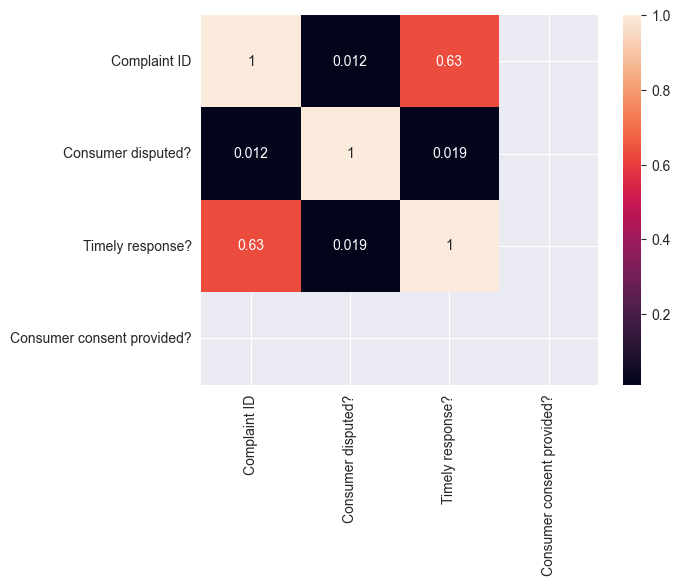

In [8]:
sns.heatmap(data=DS1_data[['Complaint ID','Consumer disputed?','Timely response?','Consumer consent provided?']].corr(),annot=True)
plt.show()

In [9]:
# create a pivot table to count the number of occurrences of each combination of Issue and Company
pivot_table = pd.pivot_table(DS1_data[["Issue","Company"]],values="Issue", index=['Issue'], columns=['Company'], aggfunc='sum', fill_value=0)

# plot the pivot table as a stacked bar chart
pivot_table.plot(kind='bar', stacked=True)

# set the title and labels for the chart
plt.title('Issues by Company')
plt.xlabel('Issue')
plt.ylabel('Count')

# show the chart
plt.show()

TypeError: no numeric data to plot